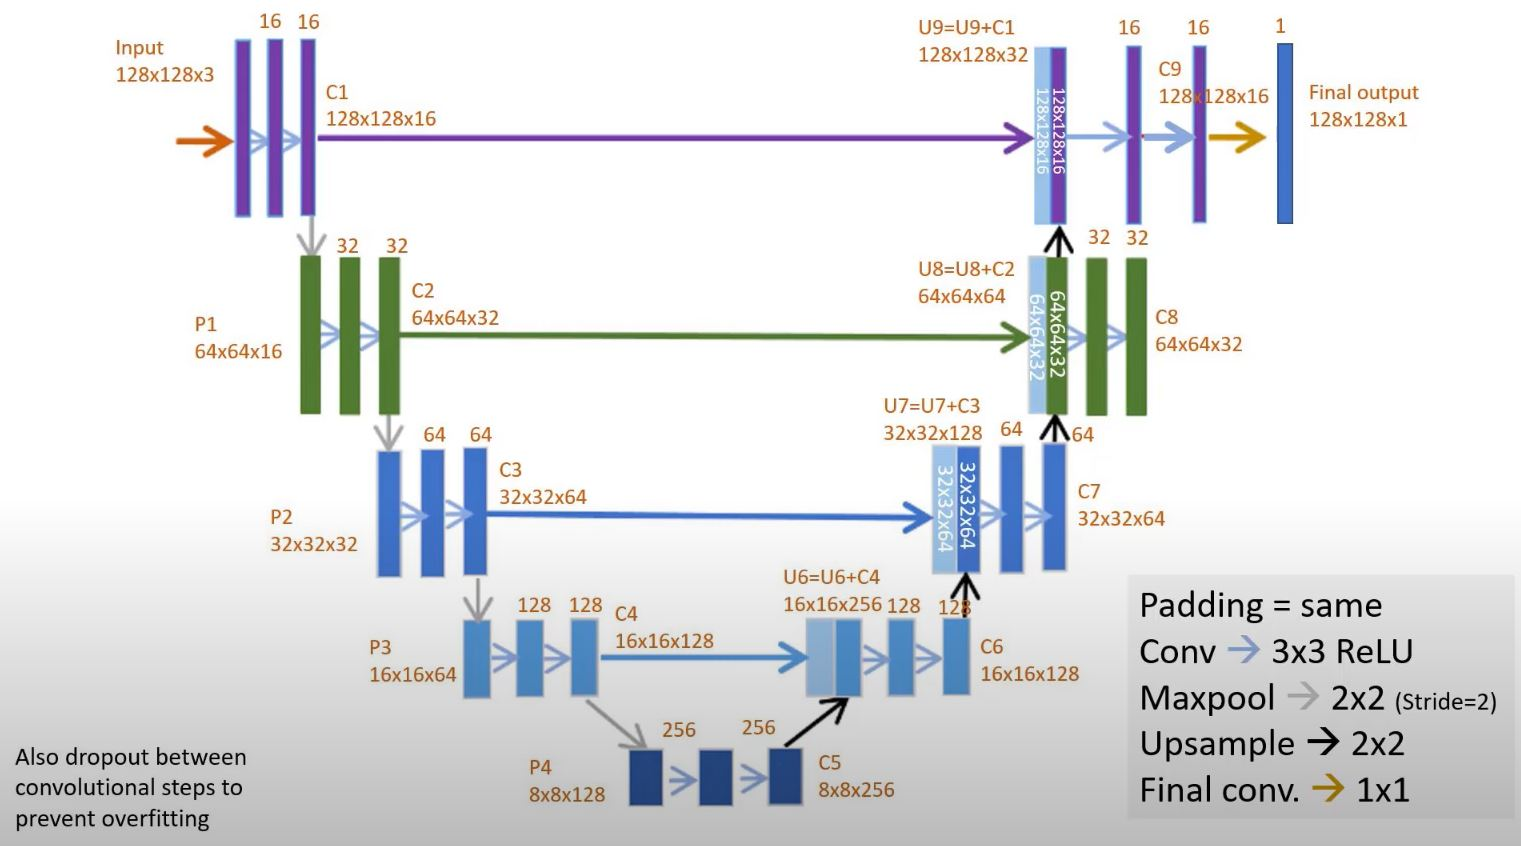

In [4]:
from IPython.display import Image
Image(filename = 'U-Net CNN Image.JPG')

In [1]:
# Getting images via navigating through the folder structure

import os
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

seed = 42
np.random.seed = seed

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_id = next(os.walk(TRAIN_PATH))[1]
test_id = next(os.walk(TEST_PATH))[1]


  0%|▌                                                                                                                                                                                                      | 2/670 [00:00<01:06, 10.08it/s]

Resizing training images and masks


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 58.61it/s]

Done loading images!


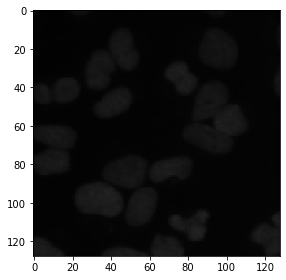

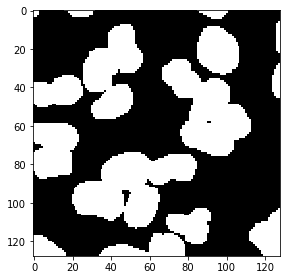

In [5]:
# Loading the training images and masks
X_train = np.zeros((len(train_id), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_id), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_id), total = len(train_id)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png.')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    
    # Fill X_train with valus from img
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Loading testing images
X_test = np.zeros((len(test_id), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
sizes_test = []
for n, id_ in tqdm(enumerate(test_id), total = len(test_id)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png.')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    
    # Fill X_train with valus from img
    X_test[n] = img
    
print('Done loading images!')

image_x = random.randint(0, len(train_id))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()



In [6]:
import tensorflow as tf

# Building the model

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS))

# Converting each pixel value from integer to floating point value
s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)


# Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)
# p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# Expansive Path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
p6 = tf.keras.layers.MaxPooling2D((2, 2))(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
p7 = tf.keras.layers.MaxPooling2D((2, 2))(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
p8 = tf.keras.layers.MaxPooling2D((2, 2))(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
p9 = tf.keras.layers.MaxPooling2D((2, 2))(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())



Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_15[0][0]                  
_______________________________________________________________________________________

In [7]:
# Model Checkpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei', verbose = 1, sace_best_only = True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir = 'logs')]

print('Checkpoints created')

Checkpoints created


In [8]:
# Using the model to fit parameters

results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 100, callbacks = callbacks)

print('Model fitting Done!')

Epoch 1/100
 1/38 [..............................] - ETA: 0s - loss: 0.6948 - accuracy: 0.4146WARNING:tensorflow:From C:\Users\yashb\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 [==============================] - 21s 541ms/step - loss: 0.5768 - accuracy: 0.7857 - val_loss: 0.4534 - val_accuracy: 0.8314
Epoch 2/100
38/38 [==============================] - 20s 521ms/step - loss: 0.3676 - accuracy: 0.8270 - val_loss: 0.2280 - val_accuracy: 0.8951
Epoch 3/100
38/38 [==============================] - 20s 523ms/step - loss: 0.2115 - accuracy: 0.9173 - val_loss: 0.1493 - val_accuracy: 0.9410
Epoch 4/100
38/38 [==============================] - 20s 523ms/step - loss: 0.1507 - accuracy: 0.9429 - val_loss: 0.1502 - val_accuracy: 0.9421
Epoch 5/100
38/38 [==============================] - 20s 527

3/3 [==============================] - 0s 66ms/step


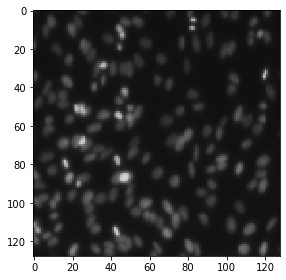

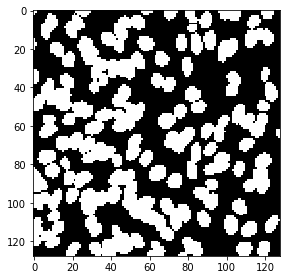

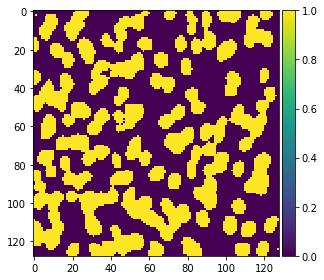

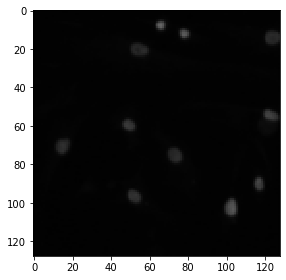

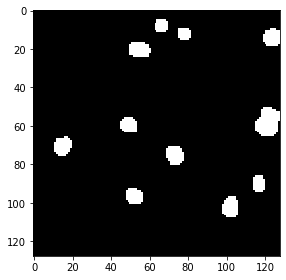

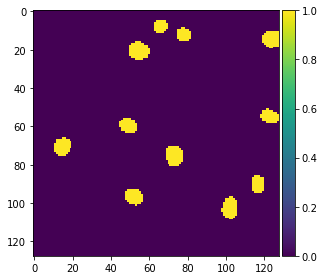

In [11]:
# Predictions and Results
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)


# Each pixel is given a value b/w 0 and 1.
# We set a threshold 0f 0.5 to binarize.
# Threshold prediction to binarize the image
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check for random training sample
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check for random validation sample
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0] * 0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0] * 0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()



